# Level 1: Rice Crop Discovery Tool Benchmark Notebook

## Load In Dependencies

To run this demonstration notebook, you will need to have the following packages imported below installed. This may take some time.  

#### Note: Environment setup
Running this notebook requires an API key.

To use your API key locally, set the environment variable <i><b>PC_SDK_SUBSCRIPTION_KEY</i></b> or use <i><b>planetary_computer.settings.set_subscription_key(<YOUR API Key>)</i></b><br>
See <a href="https://planetarycomputer.microsoft.com/docs/concepts/sas/#when-an-account-is-needed">when an account is needed for more </a>, and <a href="https://planetarycomputer.microsoft.com/account/request">request</a> an account if needed.

In [1]:
# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

# Visualization
import ipyleaflet
import matplotlib.pyplot as plt
from IPython.display import Image
import seaborn as sns

# Data Science
import numpy as np
import pandas as pd

# Feature Engineering
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Machine Learning
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score,classification_report,confusion_matrix

# Planetary Computer Tools
import pystac
import pystac_client
import odc
from pystac_client import Client
from pystac.extensions.eo import EOExtension as eo
from odc.stac import stac_load
import planetary_computer as pc
pc.settings.set_subscription_key('69d11482f0f347f4a870375623eacaff')

# Others
import requests
import rich.table
from itertools import cycle
from tqdm import tqdm
tqdm.pandas()

In [2]:
#from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

## Response Variable

Before building the model, we need to load in the rice crop presence data. We have curated for you data from a certain region in Vietnam for the year 2020. The data consists of  geo locations (Latitude and Longitude) with a tag specifying if the crop present in each geo location is rice or not.  

In [3]:
df = pd.read_csv('train-Sentinel-2.csv')
df.head()

,Latitude and Longitude,time,red_o,green_o,blue_o,nir_o,red_f,green_f,blue_f,nir_f,NDVI_o,NDVI_f,EVI_o,EVI_f,SAVI_o,SAVI_f,Class of Land
0,"(10.323727047081501, 105.2516346045924)",2021-11-11,7819.483755,8422.723397,9346.066099,7747.999305,NaN,NaN,NaN,NaN,-0.004592,NaN,0.011582,NaN,-0.006888,NaN,Rice
1,"(10.323727047081501, 105.2516346045924)",2021-11-16,7220.483762,7529.236295,8033.924712,7543.402830,NaN,NaN,NaN,NaN,0.021872,NaN,-0.086000,NaN,0.032807,NaN,Rice
2,"(10.323727047081501, 105.2516346045924)",2021-11-21,785.254969,909.071122,572.435513,3076.932723,711.999028,829.774052,497.177603,2958.218390,0.593363,0.612013,1.638694,1.603352,0.889929,0.917894,Rice
3,"(10.323727047081501, 105.2516346045924)",2021-11-26,853.906450,855.202647,474.339289,2688.530016,847.737325,849.601317,470.856904,2684.666110,0.517899,0.520022,1.077815,1.082925,0.776739,0.779923,Rice
4,"(10.323727047081501, 105.2516346045924)",2021-12-01,5755.051453,6113.884475,6647.837294,5842.471497,0.038970,0.046164,0.057875,0.046357,0.007538,0.086576,-0.023042,0.021827,0.011306,0.018931,Rice


## Model Building


<p align="justify"> Now let us select the columns required for our model building exercise. We will consider only VV and VH for our model. It does not make sense to use latitude and longitude as predictor variables as they do not have any impact on presence of rice crop.</p>

In [5]:
df_new = df[df['time'] == '2022-03-21'][['NDVI_o', 'EVI_o', 'SAVI_o', 'Class of Land']]

### Train and Test Split 

<p align="justify">We will now split the data into 70% training data and 30% test data. Scikit-learn alias “sklearn” is a robust library for machine learning in Python. The scikit-learn library has a <i><b>model_selection</b></i> module in which there is a splitting function <i><b>train_test_split</b></i>. You can use the same.</p>

In [6]:
X = df_new.drop(columns=['Class of Land']).values
y = df_new ['Class of Land'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,stratify=y,random_state=40)

### Feature Scaling 

<p align="justify"> Before initiating the model training we may have to execute different data pre-processing steps. Here we are demonstrating the scaling of VV and VH variable by using Standard Scaler.</p>

<p align = "justify">Feature Scaling is a data preprocessing step for numerical features. Many machine learning algorithms like Gradient descent methods, KNN algorithm, linear and logistic regression, etc. require data scaling to produce good results. Scikit learn provides functions that can be used to apply data scaling. Here we are using Standard Scaler.</p>

<h4 style="color:rgb(195, 52, 235)"><strong>Tip 4 </strong></h4>
<p align="justify">Participants might explore other feature scaling techniques like Min Max Scaler, Max Absolute Scaling, Robust Scaling etc.</p>

In [7]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [8]:
#import joblib
#joblib.dump(sc, 'transform.pkl')

In [9]:
import pickle
pickle.dump(sc, open('transform.pkl', "wb"))

### Model Training - Random Forest

<p justify ="align">Now that we have the data in a format appropriate for machine learning, we can begin training a model. In this demonstration notebook, we have used a binary logistic regression model from the scikit-learn library. This library offers a wide range of other models, each with the capacity for extensive parameter tuning and customization capabilities.</p>

<p justify ="align">Scikit-learn models require separation of predictor variables and the response variable. You have to store the predictor variables in array X and the response variable in the array Y. You must make sure not to include the response variable in array X. It also doesn't make sense to use latitude and longitude as predictor variables in such a confined area, so we drop those too.</p>

In [10]:
model = RandomForestClassifier()
model.fit(X_train,y_train)

RandomForestClassifier()

## Model Evaluation

Now that we have trained our model , all that is left is to evaluate it. For evaluation we will generate the classification report and will plot the confusion matrix. Scikit-learn provides many other metrics that can be used for evaluation. You can even write a code on your own.

### In-Sample Evaluation
<p align="Jutisfy"> We will be generating a classification report and a confusion matrix for the training data. It must be stressed that this is in-sample performance testing , which is the performance testing on the training dataset. These metrics are NOT truly indicative of the model's performance. You should wait to test the model performance on the test data before you feel confident about your model.</p>

In this section, we make predictions on the training set and store them in the <b><i>insample_ predictions</i></b> variable. A confusion matrix is generated to gauge the robustness of the model. 

In [11]:
insample_predictions = model.predict(X_train)

In [12]:
print("Insample Accuracy {0:.2f}%".format(100*accuracy_score(insample_predictions,y_train)))
print(classification_report(insample_predictions,y_train))

Insample Accuracy 100.00%
              precision    recall  f1-score   support

    Non Rice       1.00      1.00      1.00       210
        Rice       1.00      1.00      1.00       210

    accuracy                           1.00       420
   macro avg       1.00      1.00      1.00       420
weighted avg       1.00      1.00      1.00       420



<p> For plotting a confusion matrix we define the function <b><i>plot_confusion_matrix</i></b>.

In [13]:
def plot_confusion_matrix(true_value,predicted_value,title,labels):
    '''
    Plots a confusion matrix.
    Attributes:
    true_value - The ground truth value for comparision.
    predicted_value - The values predicted by the model.
    title - Title of the plot.
    labels - The x and y labels of the plot.
    '''
    cm = confusion_matrix(true_value,predicted_value)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap='Blues');
    ax.set_xlabel('Predicted labels');
    ax.set_ylabel('True labels'); 
    ax.set_title(title); 
    ax.xaxis.set_ticklabels(labels); 
    ax.yaxis.set_ticklabels(labels);

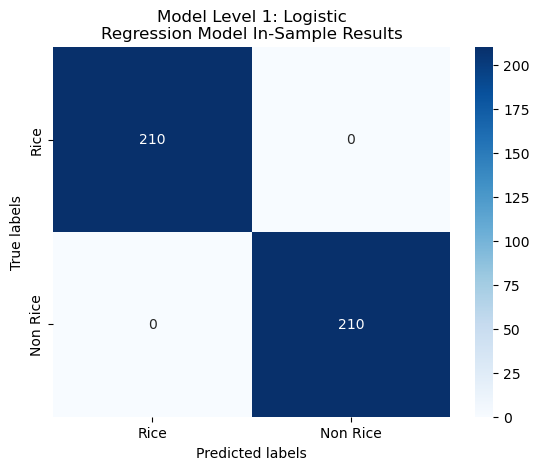

In [14]:
plot_confusion_matrix(y_train,insample_predictions,"Model Level 1: Logistic\nRegression Model In-Sample Results",['Rice', 'Non Rice'])

### Out-Sample Evaluation

When evaluating a machine learning model, it is essential to correctly and fairly evaluate the model's ability to generalize. This is because models have a tendency to overfit the dataset they are trained on. To estimate the out-of-sample performance, we will predict on the test data now. 

In [15]:
outsample_predictions = model.predict(X_test)

In [16]:
print("Accuracy {0:.2f}%".format(100*accuracy_score(outsample_predictions, y_test)))
print(classification_report(y_test, outsample_predictions))

Accuracy 100.00%
              precision    recall  f1-score   support

    Non Rice       1.00      1.00      1.00        90
        Rice       1.00      1.00      1.00        90

    accuracy                           1.00       180
   macro avg       1.00      1.00      1.00       180
weighted avg       1.00      1.00      1.00       180



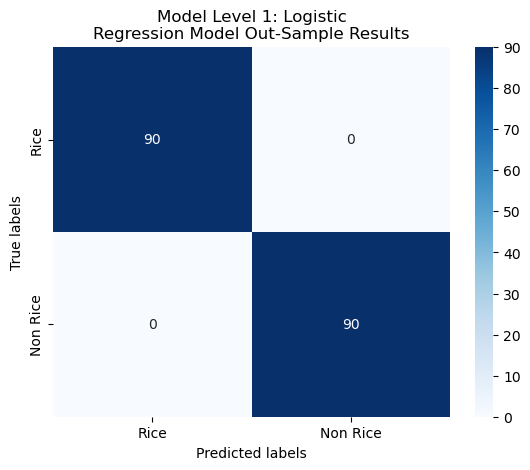

In [17]:
plot_confusion_matrix(y_test, outsample_predictions,"Model Level 1: Logistic\nRegression Model Out-Sample Results",['Rice', 'Non Rice'])

From the above, we see that the model is able to achieve an F1 score of <b>0.57</b>. This is not a very good score, so your goal is to improve this score.  

## Submission

Once you are happy with your model, you can make a submission. To make a submission, you will need to use your model to make predictions about the presence of rice crops for a set of test coordinates we have provided in the <a href="https://challenge.ey.com/api/v1/storage/admin-files/6847912254281276-63ca8b5ab12e510013520e2b-challenge_1_submission_template.csv"><b>"challenge_1_submission_template.csv"</b></a> file and upload the file onto the challenge platform.

In [18]:
#Reading the coordinates for the submission
test_file = pd.read_csv('challenge_1_submission_template.csv')
test_file.head()

,id,target
0,"(10.18019073690894, 105.32022315786804)",NaN
1,"(10.561107033461816, 105.12772097986661)",NaN
2,"(10.623790611954897, 105.13771401411867)",NaN
3,"(10.583364246115156, 105.23946127195805)",NaN
4,"(10.20744446668854, 105.26844107128906)",NaN


In [19]:
test_file.shape

(250, 2)

In [20]:
sub_file = pd.read_csv('test-Sentinel-2.csv')
sub_file.head()

,Latitude and Longitude,time,red_o,green_o,blue_o,nir_o,red_f,green_f,blue_f,nir_f,NDVI_o,NDVI_f,EVI_o,EVI_f,SAVI_o,SAVI_f
0,"(10.18019073690894, 105.32022315786804)",2021-11-11,10462.908155,11225.363783,12512.750745,10063.283823,NaN,NaN,NaN,NaN,-0.019469,NaN,0.047565,NaN,-0.029203,NaN
1,"(10.18019073690894, 105.32022315786804)",2021-11-16,8267.383062,8593.507551,9209.206759,8299.713377,NaN,NaN,NaN,NaN,0.001951,NaN,-0.007240,NaN,0.002927,NaN
2,"(10.18019073690894, 105.32022315786804)",2021-11-21,1205.828987,1023.350087,796.761356,1342.815866,633.414500,546.889175,435.336641,858.928547,0.053749,0.151114,0.131562,0.404034,0.080608,0.226595
3,"(10.18019073690894, 105.32022315786804)",2021-11-26,1096.451629,933.553564,678.006277,1350.165672,692.566453,609.244728,455.111787,1001.975435,0.103700,0.182592,0.222961,0.443270,0.155518,0.273806
4,"(10.18019073690894, 105.32022315786804)",2021-12-01,6037.030759,6384.187828,7055.618830,5542.962221,NaN,NaN,NaN,NaN,-0.042666,NaN,0.110768,NaN,-0.063996,NaN


In [21]:
sub_file.dropna().groupby('time').count()

,Latitude and Longitude,red_o,green_o,blue_o,nir_o,red_f,green_f,blue_f,nir_f,NDVI_o,NDVI_f,EVI_o,EVI_f,SAVI_o,SAVI_f
time,,,,,,,,,,,,,,,
2021-11-11,149,149,149,149,149,149,149,149,149,149,149,149,149,149,149
2021-11-21,250,250,250,250,250,250,250,250,250,250,250,250,250,250,250
2021-11-26,250,250,250,250,250,250,250,250,250,250,250,250,250,250,250
2021-12-01,145,145,145,145,145,145,145,145,145,145,145,145,145,145,145
2021-12-06,250,250,250,250,250,250,250,250,250,250,250,250,250,250,250
2021-12-11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11
2021-12-16,250,250,250,250,250,250,250,250,250,250,250,250,250,250,250
2021-12-21,250,250,250,250,250,250,250,250,250,250,250,250,250,250,250
2021-12-26,250,250,250,250,250,250,250,250,250,250,250,250,250,250,250


In [22]:
submission_vh_vv_data = sub_file[sub_file['time'] == '2022-03-21'][['NDVI_o', 'EVI_o', 'SAVI_o']]
submission_vh_vv_data.shape

(250, 3)

In [23]:
# Feature Scaling 
submission_vh_vv_data = submission_vh_vv_data.values
transformed_submission_data = sc.transform(submission_vh_vv_data)

In [24]:
type(submission_vh_vv_data)

numpy.ndarray

In [25]:
submission_vh_vv_data

array([[ 9.69127351e-02,  6.13395517e+00,  1.45357664e-01],
       [ 2.35091632e-01,  2.93098848e+00,  3.52447626e-01],
       [ 2.99206337e-01,  8.23541327e+00,  4.47055003e-01],
       [ 9.93518095e-02, -6.44512117e-01,  1.49020163e-01],
       [ 1.24007736e-01,  4.89895677e+00,  1.85998929e-01],
       [ 1.46254727e-01, -1.98558836e+00,  2.19366037e-01],
       [ 1.16086050e-01, -1.45191431e+00,  1.74117299e-01],
       [ 2.43632378e-01, -8.52510920e+01,  3.65426944e-01],
       [ 9.97928437e-02, -6.47976161e-01,  1.49681676e-01],
       [ 3.08366729e-01,  5.52108960e+00,  4.62411451e-01],
       [ 1.18097161e-01, -1.51073715e+00,  1.77133862e-01],
       [ 2.97034553e-01,  2.83396000e+00,  4.45469594e-01],
       [ 3.02776433e-01,  3.97679419e+00,  4.54022883e-01],
       [ 2.41333194e-01,  1.16834746e+01,  3.61976202e-01],
       [ 1.03071736e-01, -6.89149739e-01,  1.54599716e-01],
       [ 1.00351637e-01, -6.55011548e-01,  1.50519816e-01],
       [ 9.36998449e-02,  5.55543500e+00

In [26]:
transformed_submission_data

array([[-2.56895693e+00,  5.54319738e-01, -2.56855914e+00],
       [ 1.44710757e+00,  3.38772039e-01,  1.44481036e+00],
       [ 3.31055267e+00,  6.95740020e-01,  3.27828581e+00],
       [-2.49806709e+00,  9.81542000e-02, -2.49758051e+00],
       [-1.78146133e+00,  4.71208956e-01, -1.78093809e+00],
       [-1.13486947e+00,  7.90477637e-03, -1.13428902e+00],
       [-2.01169912e+00,  4.38190476e-02, -2.01120213e+00],
       [ 1.69533784e+00, -5.59555270e+00,  1.69634741e+00],
       [-2.48524877e+00,  9.79210828e-02, -2.48476050e+00],
       [ 3.57679251e+00,  5.13076173e-01,  3.57589125e+00],
       [-1.95324772e+00,  3.98604898e-02, -1.95274164e+00],
       [ 3.24743143e+00,  3.32242385e-01,  3.24756084e+00],
       [ 3.41431481e+00,  4.09150858e-01,  3.41332218e+00],
       [ 1.62851382e+00,  9.27781674e-01,  1.62947260e+00],
       [-2.38995026e+00,  9.51502548e-02, -2.38944969e+00],
       [-2.46900785e+00,  9.74476276e-02, -2.46851748e+00],
       [-2.66233714e+00,  5.15387490e-01

In [27]:
#Making predictions
final_predictions = model.predict(transformed_submission_data)
final_prediction_series = pd.Series(final_predictions)

In [28]:
final_predictions.tolist()[0]

'Non Rice'

In [29]:
#Combining the results into dataframe
submission_df = pd.DataFrame({'id':test_file['id'].values, 'target':final_prediction_series.values})

In [30]:
#Displaying the sample submission dataframe
display(submission_df)

,id,target
0,"(10.18019073690894, 105.32022315786804)",Non Rice
1,"(10.561107033461816, 105.12772097986661)",Non Rice
2,"(10.623790611954897, 105.13771401411867)",Non Rice
3,"(10.583364246115156, 105.23946127195805)",Non Rice
4,"(10.20744446668854, 105.26844107128906)",Non Rice
...,...,...
245,"(10.308283266873062, 105.50872812216863)",Non Rice
246,"(10.582910017285496, 105.23991550078767)",Non Rice
247,"(10.581547330796518, 105.23991550078767)",Non Rice
248,"(10.629241357910818, 105.15315779432643)",Rice


In [31]:
submission_df['target'].value_counts()

Non Rice    239
Rice         11
Name: target, dtype: int64

In [32]:
#Dumping the predictions into a csv file.
submission_df.to_csv("submission(11).csv",index = False)

In [33]:
#import pickle

In [34]:
#with open('model.pkl', 'wb') as f:
    #pickle.dump(model, f)

In [35]:
import pickle
pickle.dump(model, open('sentinel2.pkl', "wb"))

## Conclusion

Now that you have learned a basic approach to model training, it’s time to try your own approach! Feel free to modify any of the functions presented in this notebook. We look forward to seeing your version of the model and the results. Best of luck with the challenge!